In [1]:
%matplotlib inline
import os
import re

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.scripts.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/lfs1/home/jackyu/anaconda3/envs/work/lib/python3.4/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.scripts.g1_threshold' from '/lfs1/home/jackyu/climatools/climatools/scripts/g1_threshold.py'>

In [2]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'tsfc', 
            'pressure_reference_high',
            'temperature_reference_high', 
            'pressure_reference_low', 
            'temperature_reference_low',
            'ighigh', 
            'ng', 
            'absth',
            'wgt']


def pattern_assign(name):
    return ''' 
    parameter .* :: .* ({} .* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/]+ {}[^,] [^/]+ / [^/]+ /)
    '''.format(name)

def pattern_atmpro():
    return '''
    (include \s+ '.*\.pro')
    '''


def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [3]:
analysis = scripts.Analysis()

In [4]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'o3',
                          'band05_wn_980_1100',
                          'P_50_T_250_min_1e-20_max_1.899e-19_ng_4_dlogN_0.426_0.426_0.426__P_1_T_250_ng_3',
                          'wgt_1_.9_.85_.7_.6_.5_.4',
                          'subarctic_winter__dv_.005')
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.load_data()

In [5]:
crdx_wgt = analysis.model('wgt')
crdx_wgt.type_model = 'crd'
crdx_wgt.rundir = os.path.join('/lfs1/home/jackyu/radiation',
                          'crd/LW/examples',
                          'separate_g_groups',
                          'study__lblnew_g1_threshold',
                          'o3',
                          'band05_wn_980_1100',
                          'P_50_T_250_min_1e-20_max_1.899e-19_ng_4_dlogN_0.426_0.426_0.426__P_1_T_250_ng_3',
                          'wgt_1_.9_.85_.7_.6_.5_.4',
                          'subarctic_winter__dv_.005')
crdx_wgt.fpath_flux = 'output_xfluxg.dat'
crdx_wgt.fpath_coolr = 'output_xcoolrg.dat'
crdx_wgt.linestyle = '--'
crdx_wgt.load_data()

In [6]:
fig = analysis.fig_fluxcoolr('fig1')
fig.ggroups = list(range(1, 7 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-4, 200)

In [7]:
fig2 = analysis.fig_fluxcoolr('fig2',
                              ggroups=list(range(1, 7 + 1)),
                              vartypes=['cooling rate'])
fig2.vars_plot['cooling rate'] = ['coolrg']
fig2.colors['flug'] = 'darkred'
fig2.colors['fnetg'] = 'lightcoral'
fig2.colors['coolrg'] = 'blue'
fig2.varlims_from_indexrange['linear'] = (50, 1050)
fig2.varlims_from_indexrange['log'] = (1e-4, 200)

In [8]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = np.sort(
    xr.concat(
        [crd.data['flux'].coords['pressure'].isel(pressure=[0, -1]),
         crd.data['flux'].coords['pressure'].sel(pressure=300, 
                                                 method='nearest')],
        dim='pressure'))

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [9]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])
        
table_flux.at_pressures = np.sort(
    xr.concat(
        [crd.data['flux'].coords['pressure'].isel(pressure=[0, -1]),
         crd.data['flux'].coords['pressure'].sel(pressure=300, 
                                                 method='nearest')],
        dim='pressure'))

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [10]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [11]:
# print some input parameters

with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, innames())))

vstar = 980

nband = 120

nv = 200

dv = 0.005

tsfc = 257.0

pressure_reference_high = 1.

temperature_reference_high = 250.

pressure_reference_low = 50.

temperature_reference_low = 250.

ighigh = 4

ngas = 6      

ng = 7

data absth(:, 1)
!     &    /2.000000e-22, 3.8470878e-22, 7.40004238e-22,
!     &     1.423430e-21, 1.10733E-20,   2.93308E-19,
!     &     2.31589E-17/

data absth(:, 2)
     &    /1.000e-20,  2.668e-20,  7.117e-20,
     &     1.899e-19,   2.633e-19,   3.652e-19,
     &     5.065e-19/

data wgt
     &     /  1.00, 0.90, 0.85,
     &     0.70, 0.60, 0.50, 0.40/

include 'saw75.pro'


In [12]:
fig.display_hrefanchor()

In [13]:
fig2.display_hrefanchor()

In [14]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()
table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [15]:
table_dgdgs.display_hrefanchor()

In [16]:
s_abscom = 'Overall absth'
display.display(display.HTML(climahtml.getHTML_hrefanchor(s_abscom)))

In [17]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: flux, cooling rate g-group 1

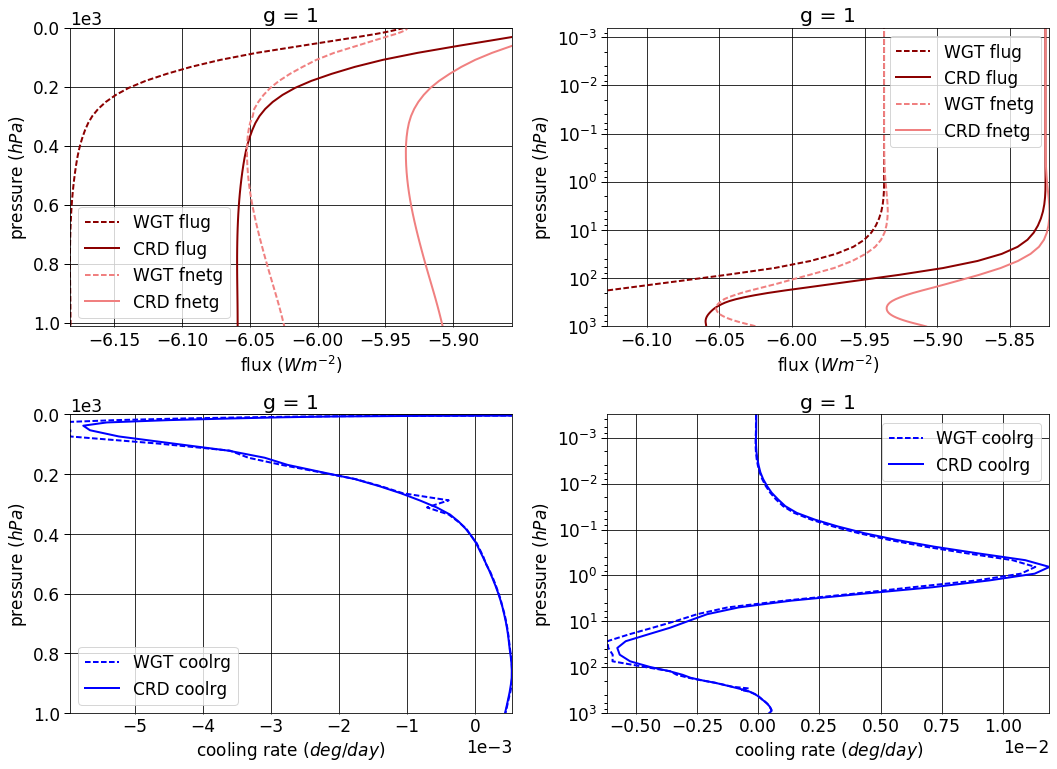

# Figure: flux, cooling rate g-group 2

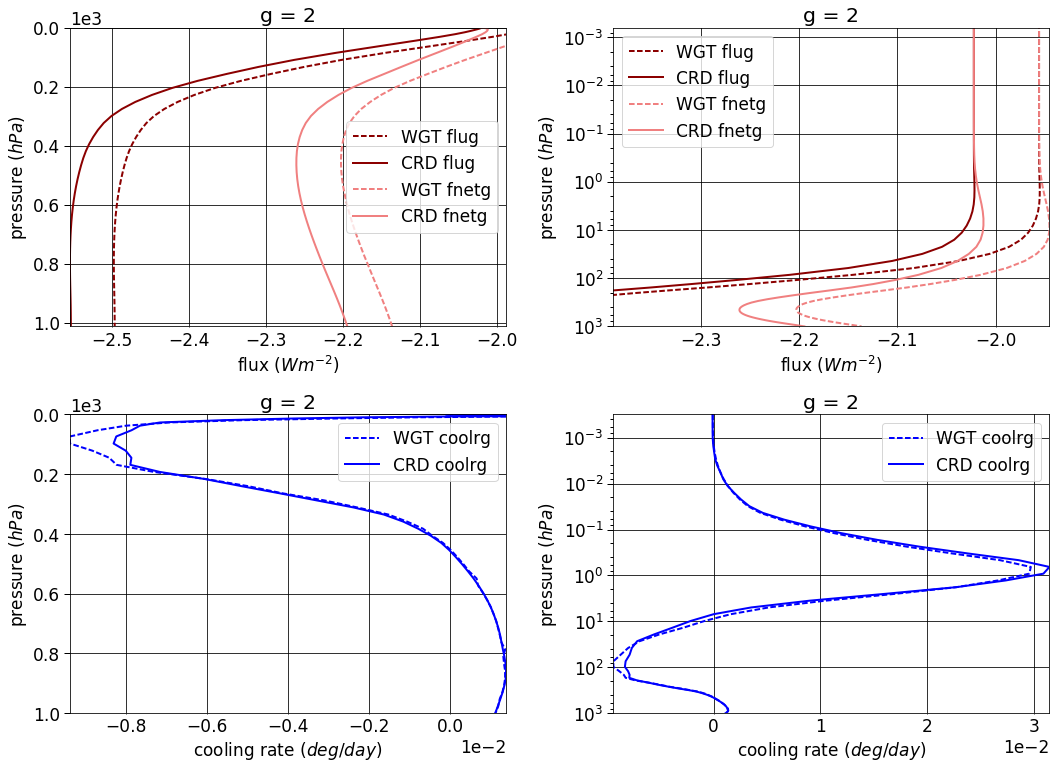

# Figure: flux, cooling rate g-group 3

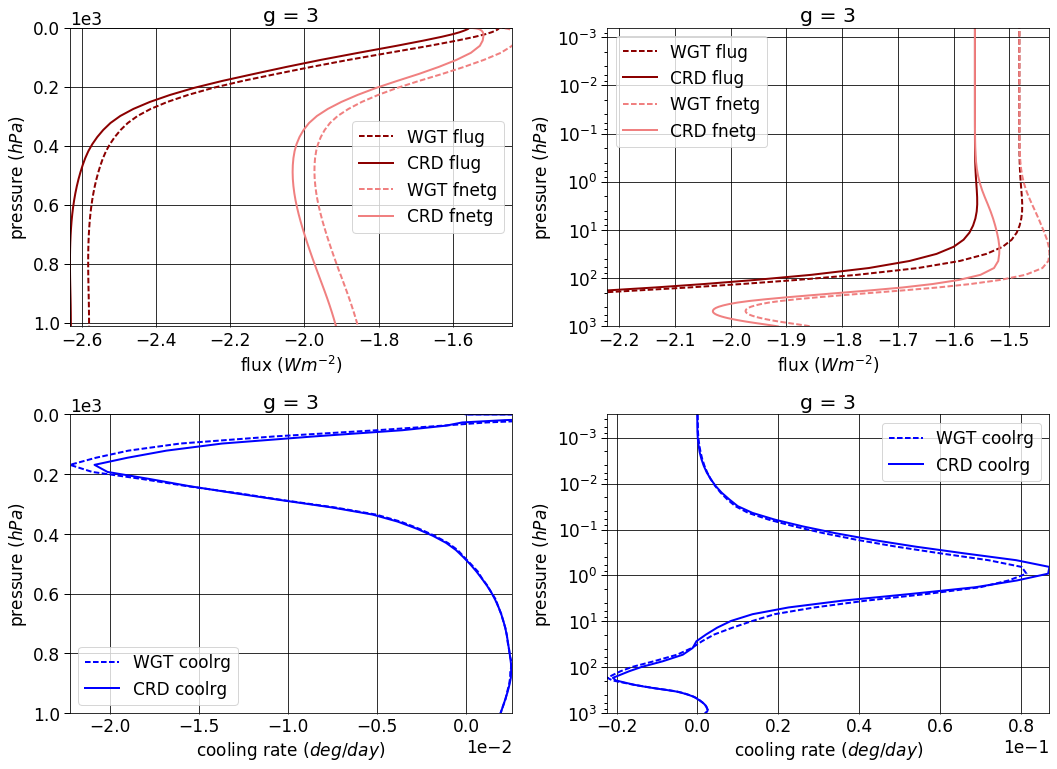

# Figure: flux, cooling rate g-group 4

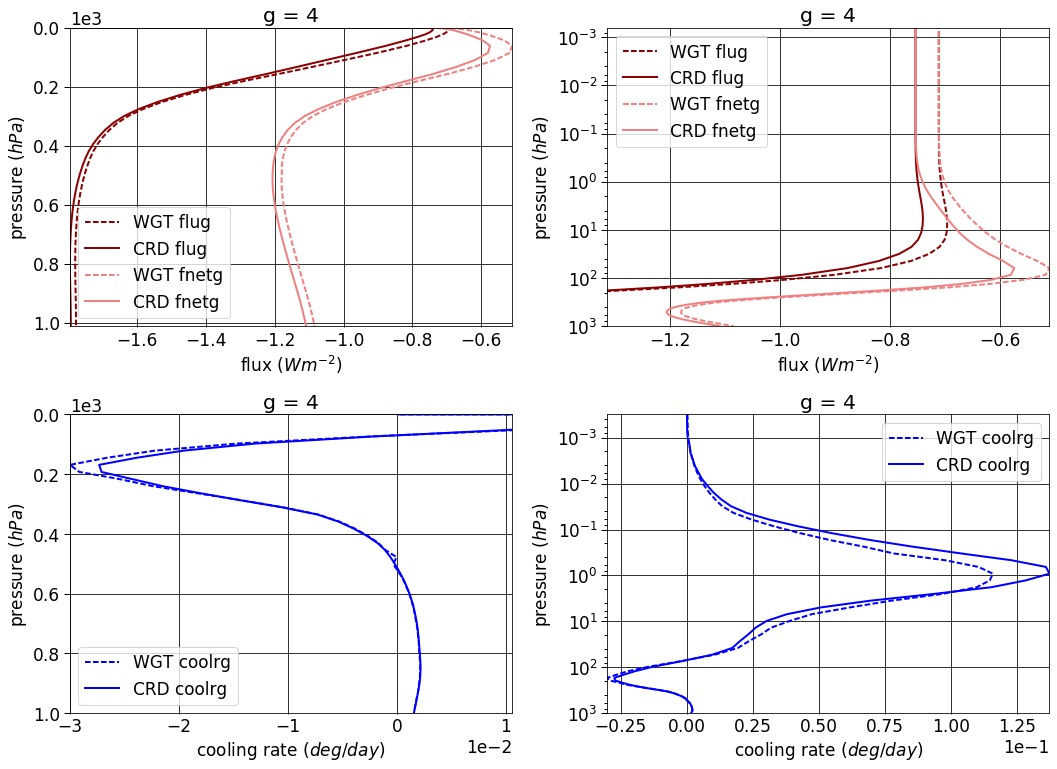

# Figure: flux, cooling rate g-group 5

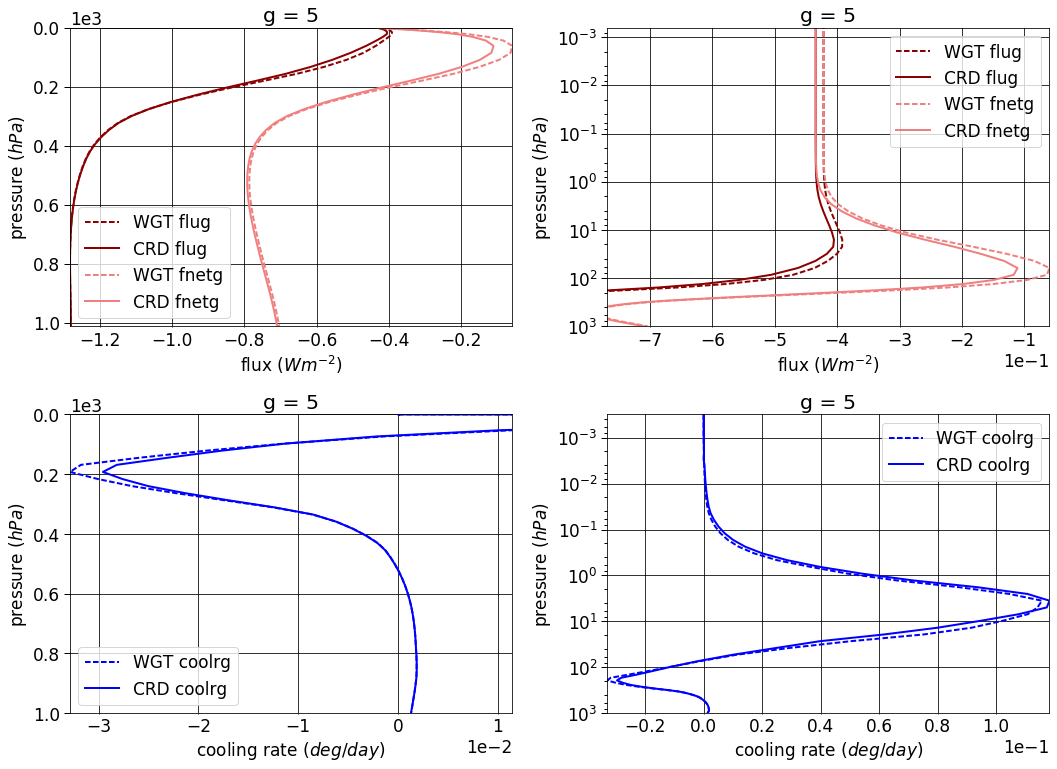

# Figure: flux, cooling rate g-group 6

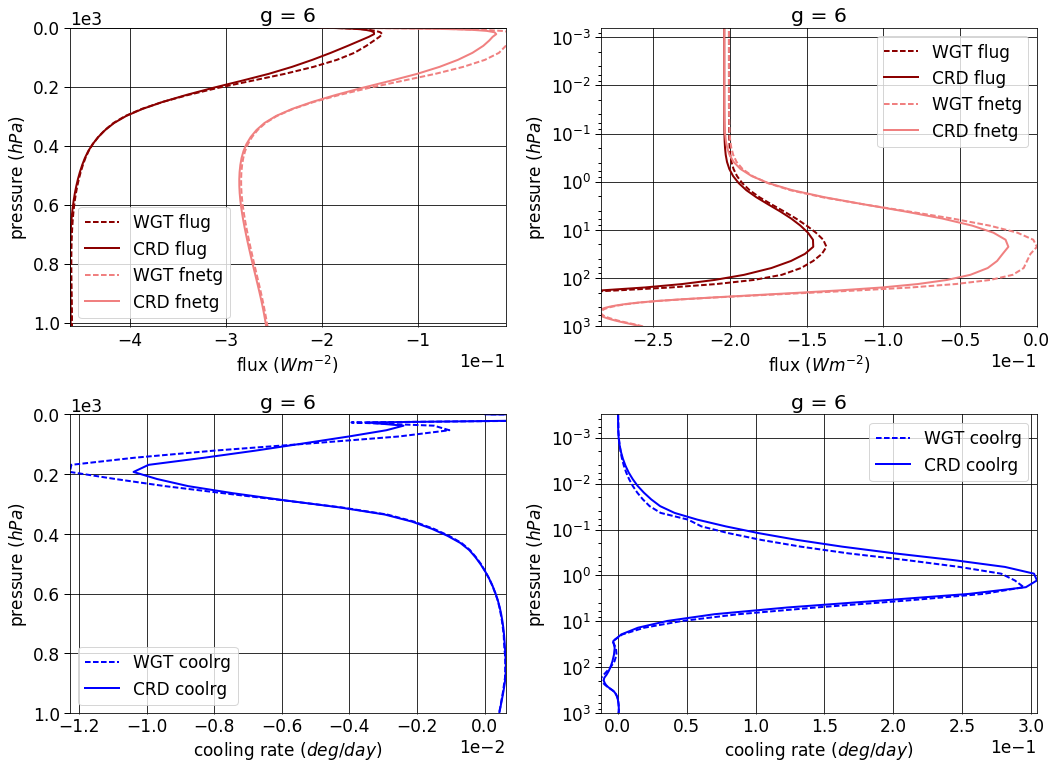

# Figure: flux, cooling rate g-group 7

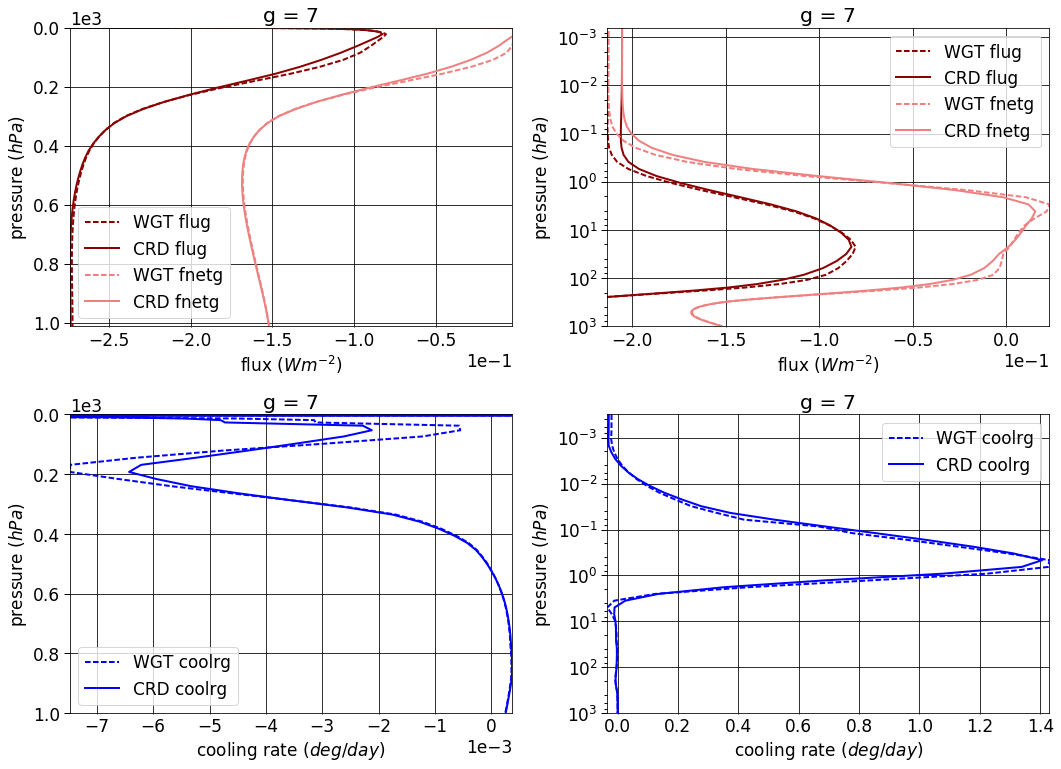

# Figure: flux, cooling rate g-group total

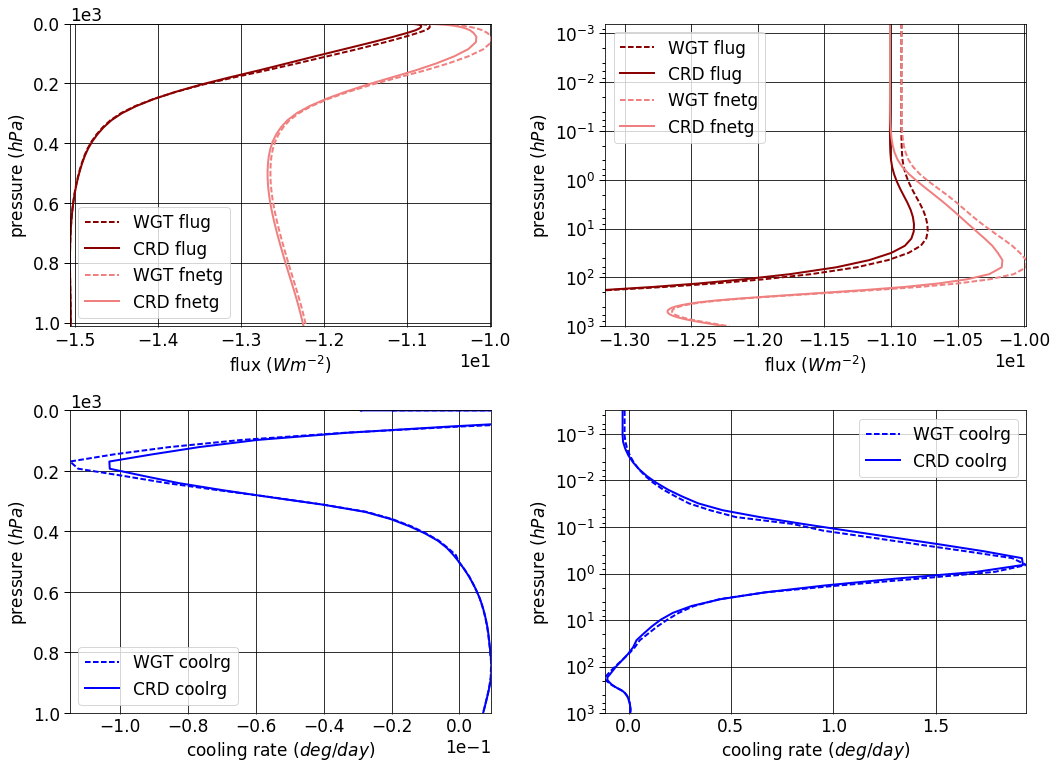

In [18]:
matplotlib.rcParams.update({'font.size': 17,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


# Figure: cooling rate g-group 1

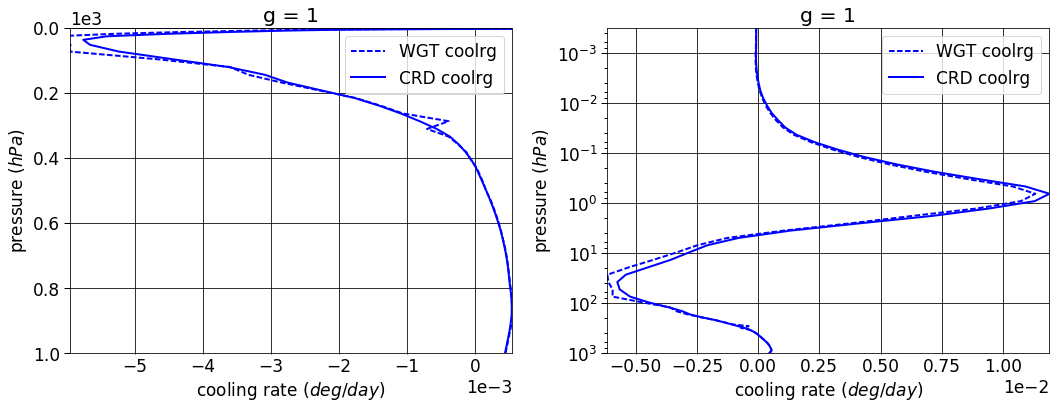

# Figure: cooling rate g-group 2

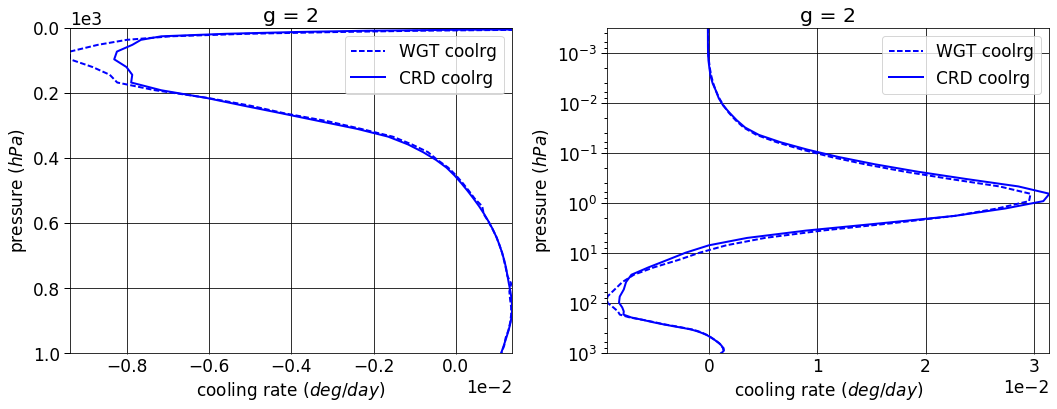

# Figure: cooling rate g-group 3

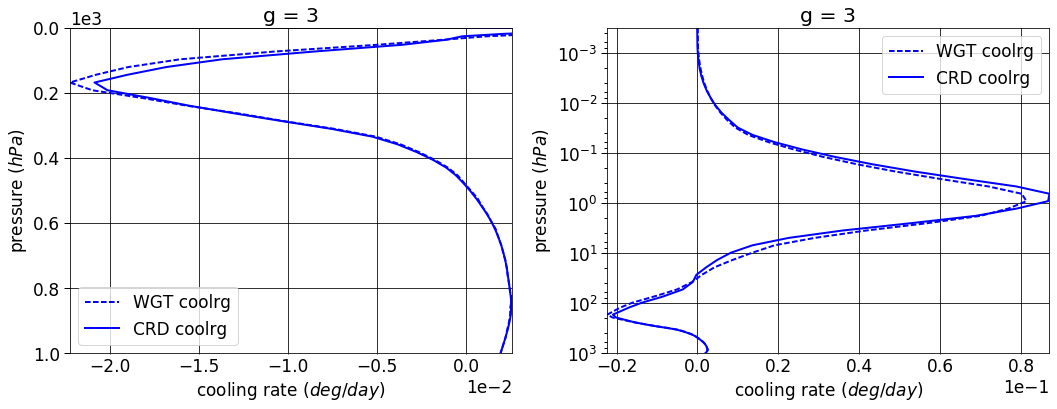

# Figure: cooling rate g-group 4

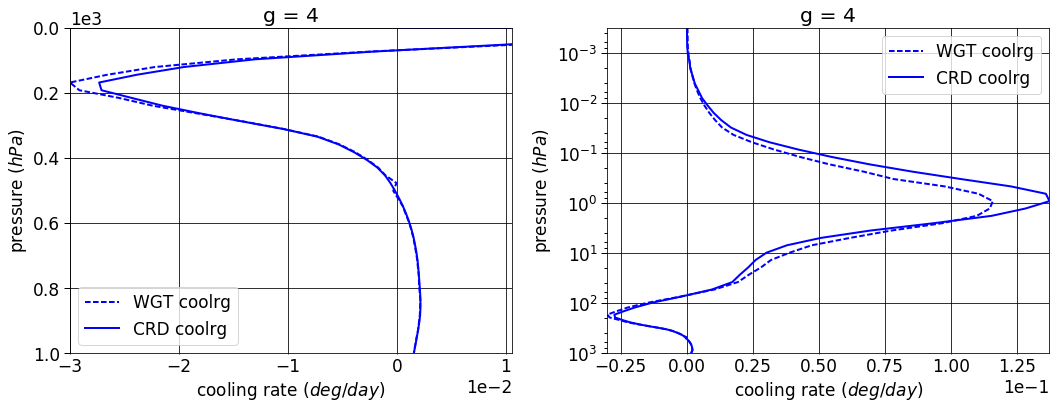

# Figure: cooling rate g-group 5

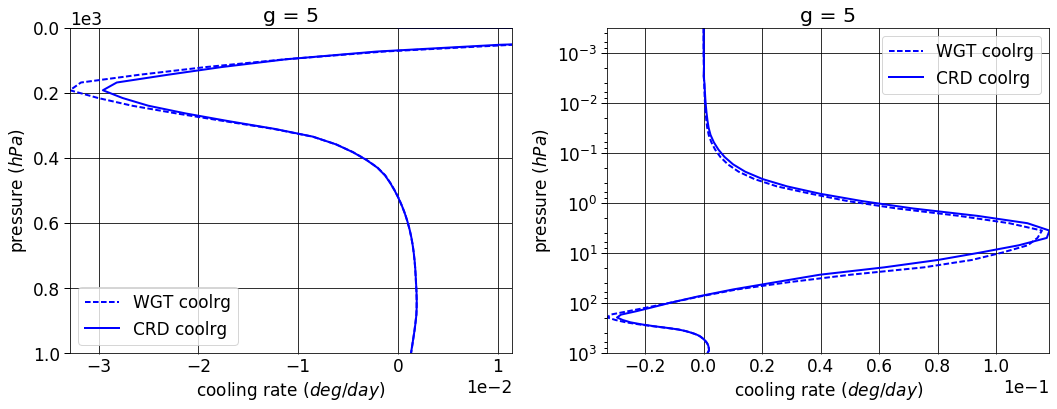

# Figure: cooling rate g-group 6

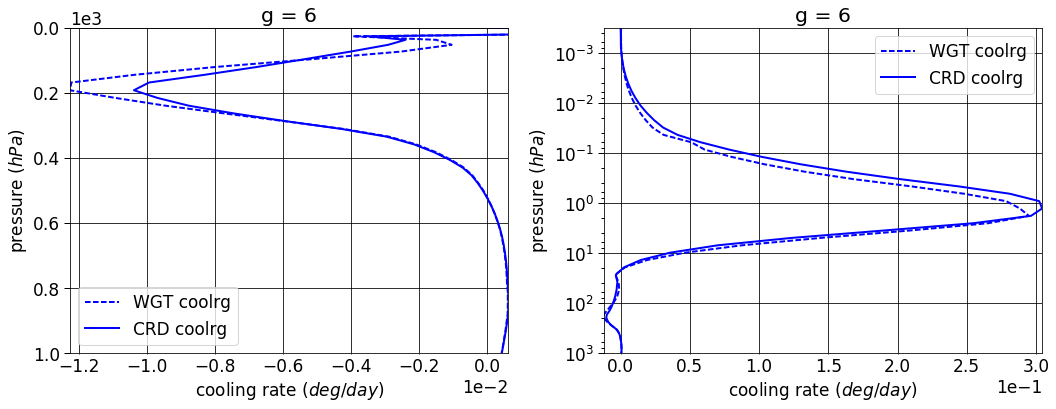

# Figure: cooling rate g-group 7

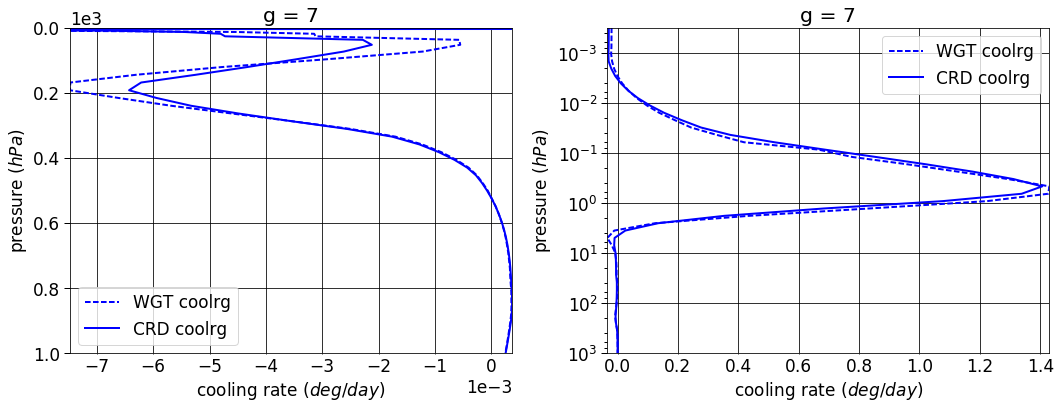

# Figure: cooling rate g-group total

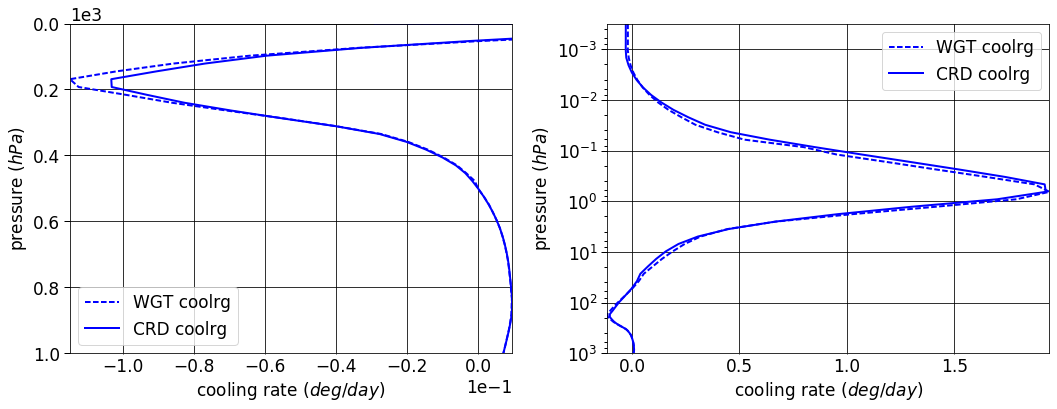

In [19]:
matplotlib.rcParams.update({'font.size': 17,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 
fig2.plot(analysis)

In [20]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -5.825540  0.000000 -5.825540
  299.75   46    -6.042791  0.111848 -5.930943
  1013.00  76    -6.058956  0.151338 -5.907618
2 0.00     1     -2.022082  0.000000 -2.022082
  299.75   46    -2.500787  0.258930 -2.241857
  1013.00  76    -2.553554  0.358886 -2.194668
3 0.00     1     -1.561577  0.000000 -1.561577
  299.75   46    -2.496552  0.530137 -1.966415
  1013.00  76    -2.629711  0.714759 -1.914952
4 0.00     1     -0.754165  0.000000 -0.754165
  299.75   46    -1.638168  0.525289 -1.112879
  1013.00  76    -1.793824  0.684683 -1.109141
5 0.00     1     -0.434485  0.000000 -0.434485
  299.75   46    -1.112035  0.430343 -0.681692
  1013.00  76    -1.280318  0.570834 -0.709485
6 0.00     1     -0.203824  0.000000 -0.203824
  299.75   46    -0.403904  0.156077 -0.247826
  1013.00  76    -0.461721  0.203624 -0.258097
7 0.00     1     -0.205568  0.000000 -0.205568
  299.75   46    -0.239023  0.093241 -0.145782
  1013.00  76    -0.273321  0.121246 -0.152074


WGT


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -5.936584  0.000000 -5.936584
  299.75   46    -6.166189  0.118406 -6.047783
  1013.00  76    -6.182364  0.157858 -6.024506
2 0.00     1     -1.955699  0.000000 -1.955699
  299.75   46    -2.445541  0.260163 -2.185378
  1013.00  76    -2.496652  0.360190 -2.136462
3 0.00     1     -1.481860  0.000000 -1.481860
  299.75   46    -2.450028  0.539570 -1.910458
  1013.00  76    -2.580688  0.724909 -1.855780
4 0.00     1     -0.711697  0.000000 -0.711697
  299.75   46    -1.626266  0.537040 -1.089225
  1013.00  76    -1.778574  0.694043 -1.084531
5 0.00     1     -0.421891  0.000000 -0.421891
  299.75   46    -1.113736  0.438017 -0.675720
  1013.00  76    -1.280624  0.576879 -0.703745
6 0.00     1     -0.200748  0.000000 -0.200748
  299.75   46    -0.404731  0.157750 -0.246980
  1013.00  76    -0.460322  0.203553 -0.256769
7 0.00     1     -0.212963  0.000000 -0.212963
  299.75   46    -0.239497  0.093353 -0.146144
  1013.00  76    -0.272180  0.120205 -0.151975


WGT - CRD


flug      fldg     fnetg
g pressure level                              
1 0.00     1     -0.111044  0.000000 -0.111044
  299.75   46    -0.123398  0.006558 -0.116840
  1013.00  76    -0.123408  0.006520 -0.116888
2 0.00     1      0.066383  0.000000  0.066383
  299.75   46     0.055246  0.001233  0.056479
  1013.00  76     0.056902  0.001304  0.058206
3 0.00     1      0.079717  0.000000  0.079717
  299.75   46     0.046524  0.009433  0.055957
  1013.00  76     0.049022  0.010150  0.059172
4 0.00     1      0.042468  0.000000  0.042468
  299.75   46     0.011902  0.011752  0.023654
  1013.00  76     0.015249  0.009360  0.024609
5 0.00     1      0.012594  0.000000  0.012594
  299.75   46    -0.001701  0.007673  0.005972
  1013.00  76    -0.000305  0.006045  0.005740
6 0.00     1      0.003076  0.000000  0.003076
  299.75   46    -0.000827  0.001673  0.000846
  1013.00  76     0.001399 -0.000071  0.001328
7 0.00     1     -0.007395  0.000000 -0.007395
  299.75   46    -0.000474  0.000112 -0.000362
  1013.00  76     0.001141 -0.001042  0.000099

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000075
  1001.112500 75     0.000440
2 0.000312    1     -0.000101
  1001.112500 75     0.001103
3 0.000312    1     -0.000047
  1001.112500 75     0.001906
4 0.000312    1      0.000085
  1001.112500 75     0.001559
5 0.000312    1      0.000035
  1001.112500 75     0.001284
6 0.000312    1      0.000028
  1001.112500 75     0.000435
7 0.000312    1     -0.028873
  1001.112500 75     0.000256


WGT


coolrg
g pressure    layer          
1 0.000312    1     -0.000086
  1001.112500 75     0.000448
2 0.000312    1     -0.000076
  1001.112500 75     0.001108
3 0.000312    1      0.000071
  1001.112500 75     0.001918
4 0.000312    1      0.000296
  1001.112500 75     0.001556
5 0.000312    1      0.000023
  1001.112500 75     0.001293
6 0.000312    1      0.000180
  1001.112500 75     0.000428
7 0.000312    1     -0.019730
  1001.112500 75     0.000250


WGT - CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.000010
  1001.112500 75     0.000008
2 0.000312    1      0.000025
  1001.112500 75     0.000005
3 0.000312    1      0.000118
  1001.112500 75     0.000011
4 0.000312    1      0.000211
  1001.112500 75    -0.000003
5 0.000312    1     -0.000012
  1001.112500 75     0.000009
6 0.000312    1      0.000152
  1001.112500 75    -0.000007
7 0.000312    1      0.009143
  1001.112500 75    -0.000006

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-11.007242,0.000000,-11.007242
299.75,46,-14.433260,2.105866,-12.327394
1013.00,76,-15.051403,2.805370,-12.246033



WGT


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,-10.921443,0.000000,-10.921443
299.75,46,-14.445988,2.144300,-12.301688
1013.00,76,-15.051403,2.837636,-12.213767



WGT - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.00,1,8.579853e-02,0.000000,0.085799
299.75,46,-1.272798e-02,0.038434,0.025706
1013.00,76,7.000000e-08,0.032266,0.032266


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.028947
1001.112500,75,0.006984



WGT


,,coolrg
pressure,layer,
0.000312,1,-0.019322
1001.112500,75,0.007000



WGT - CRD


,,coolrg
pressure,layer,
0.000312,1,0.009626
1001.112500,75,0.000017


In [21]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.410750,0.402196
2,0.165875,0.169859
3,0.171458,0.174865
4,0.118167,0.119209
5,0.085083,0.085039
6,0.030583,0.030673
7,0.018083,0.018159


In [22]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.000000e-20
2,2.668000e-20
3,7.117000e-20
4,1.899000e-19
5,7.154854e-20
6,1.287241e-18


In [23]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')